# Capstone EDA

## START

In [1]:
import datetime as dt

start_time = dt.datetime.now()
print(f"Execution started on {start_time.strftime('%d-%m-%Y at %H:%M:%S')}")

Execution started on 04-02-2023 at 09:55:17


## Importing Necessary Modules

In [2]:
!pip3 install -q numpy==1.21.6
!pip3 install -q basemap
!pip3 install -q ipython-autotime
!pip3 install -q pandas
!pip3 install -q polars
!pip3 install -q pyarrow
!pip3 install -q requests
!pip3 install -q seaborn
!pip3 install -q tqdm

%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 863.9/863.9 KB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 KB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 72.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.23.5 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.2/15.2 MB 77.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 59.3 MB/s eta 0:00:00
time: 529 µs (started: 2023-02-04 09:56:08 +00:00)


In [3]:
import csv
import gc
import glob
import numpy as np
import os
import pandas as pd
import polars as pl
import requests
import seaborn as sns
import shutil

from math import ceil
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

time: 1.25 s (started: 2023-02-04 09:56:08 +00:00)


## Download Data Files

In [4]:
def download_file_s3(s3_url: str, name: str = None):
    # make an HTTP request within a context manager
    with requests.get(s3_url, stream=True) as r:
        
        # check header to get content length, in bytes
        total_length = int(r.headers.get("Content-Length"))
        
        # implement progress bar via tqdm
        with tqdm.wrapattr(r.raw, "read", total=total_length, desc="") as raw:
        
            # save the output to a file
            name = f"{os.path.basename(r.url)}" if not name else name
            with open(name, 'wb') as output:
                shutil.copyfileobj(raw, output)

time: 1.3 ms (started: 2023-02-04 09:56:09 +00:00)


In [5]:
def download_file_google_drive(id: str, f_name: str, f_save_path: str=""):
    """
    Download file from Google Drive

    Args:
        id (str): Google Drive File ID
        f_name (str): File name
        f_save_path (str): File save path. 
            default: Current working directory
    """
    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value
        return None

    def save_response_content(response, destination):
        CHUNK_SIZE = 32768
        with open(destination, "wb") as f:
            TOTAL_FILE_SIZE_BYTES = int(response.headers.get('content-length', 0))
            with tqdm(total=TOTAL_FILE_SIZE_BYTES, unit='iB', unit_scale=True) as pbar:
                for chunk in response.iter_content(CHUNK_SIZE):
                    pbar.update(len(chunk))
                    if chunk: # filter out keep-alive new chunks
                        f.write(chunk)

    URL = "https://drive.google.com/uc?export=download&confirm=yTib"

    f_save_path = os.getcwd() if not f_save_path else f_save_path.rstrip("/")
    destination = f"{f_save_path}/{f_name}"

    session = requests.Session()
    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)
    
    save_response_content(response, destination)

time: 2.39 ms (started: 2023-02-04 09:56:09 +00:00)


In [6]:
data_location = "GoogleDrive"

if data_location == "GoogleDrive":
    data_files = {"NonEventData.parquet": "1zlfONRymDIJlMPnYEjURnBMXLqzAJ8cU",
                  "EventData.parquet": "1lyIq_vZc5drC_n2Exw1d9ZGrao0glvUO", 
                  "AppData_01.parquet": "1uRvv8sEN1Hcp1AASbO2qwBiA3PilpcjS", 
                  "AppData_02.parquet": "1qbP1EpEhcQTaM2EHGIh3v8iBNU2X3Ycg",
                  "AppData_03.parquet": "1DBxnmA8Wrx9x0Xi6znvCJsU8C-uGEBgN",
                  "AppData_04.parquet": "1Uh3MymQd_Ddf-s3yqbe_F6PggKivHEBv",
                  "AppData_05.parquet": "1cY2wv1SaVZRkBUF_jlEuWrt3QN4zlHm0",
                  "train_test_split.csv": "1654MWotxtWth19b_VWPnyeGLGqR94nK8"}
    for file_name, file_id in data_files.items():
        if not os.path.exists(file_name):
            print(f"Downloading data file, '{file_name}' from GoogleDrive.")
            download_file_google_drive(file_id, file_name)
        else:
            print(f"Data file, '{file_name}', already present in the workspace.")
elif data_location == "S3":
    data_files = {"NonEventData": "https://ravigorticapstonebucket.s3.amazonaws.com/Captsone/noneventdata/non_event_data.csv",
                  "EventData": "https://ravigorticapstonebucket.s3.amazonaws.com/Captsone/eventdata/event_data.csv", 
                  "AppData": "https://ravigorticapstonebucket.s3.amazonaws.com/Captsone/appdata/app_data.csv"}

    # Checking if the files are already downloaded.
    for file_name, file_s3_url in data_files.items():
        file_name += ".csv"
        if not os.path.exists(file_name):
            print(f"Downloading data file, '{file_name}', from S3 with URI, '{file_s3_url}'.")
            download_file_s3(s3_url=file_s3_url, name=file_name)
        else:
            print(f"Data file, '{file_name}', already present in the workspace.")
else:
    print("Data locaiton should be either: 'GoogleDrive' or 'S3'")

  0%|          | 0.00/2.04M [00:00<?, ?iB/s]

  0%|          | 0.00/35.5M [00:00<?, ?iB/s]

  0%|          | 0.00/233M [00:00<?, ?iB/s]

  0%|          | 0.00/185M [00:00<?, ?iB/s]

  0%|          | 0.00/207M [00:00<?, ?iB/s]

  0%|          | 0.00/215M [00:00<?, ?iB/s]

  0%|          | 0.00/294M [00:00<?, ?iB/s]

  0%|          | 0.00/2.85M [00:00<?, ?iB/s]

time: 17 s (started: 2023-02-04 09:56:09 +00:00)


## Load Data

### Non-Event Data

In [7]:
non_event_data_df = pl.scan_parquet("NonEventData.parquet", low_memory=True)

# Changing Data types of columns to optmize for size
non_event_data_df = non_event_data_df.with_column(pl.col('device_id').cast(pl.Int64))
non_event_data_df = non_event_data_df.with_column(pl.col('gender').cast(pl.Categorical))
non_event_data_df = non_event_data_df.with_column(pl.col('group_train').cast(pl.Categorical))
non_event_data_df = non_event_data_df.with_column(pl.col('age').cast(pl.Int8))
non_event_data_df = non_event_data_df.with_column(pl.col('phone_brand').cast(pl.Categorical))

time: 2.7 ms (started: 2023-02-04 09:56:26 +00:00)


In [8]:
non_event_data_df.head().fetch(n_rows=5, streaming=True)

device_id,gender,age,group_train,phone_brand,device_model
i64,cat,i8,cat,cat,str
-1819925713085810000,"""F""",23,"""F0-24""","""OPPO""","""N1 Mini"""
3670076507269740000,"""M""",33,"""M32+""","""Meizu""","""menote1 2"""
5333872006968810000,"""M""",34,"""M32+""","""Xiaomi""","""xnote"""
4216041491117040000,"""M""",60,"""M32+""","""lshi""","""ihv1"""
-3441149835823130000,"""M""",30,"""M25-32""","""Huawei""","""è£è€€ç•…çŽ©5X..."


time: 41.2 ms (started: 2023-02-04 09:56:26 +00:00)


### Event Data

In [9]:
event_data_df = pl.scan_parquet("EventData.parquet", low_memory=True)

# Changing Data types of columns to optmize for size
event_data_df = event_data_df.with_column(pl.col('device_id').cast(pl.Int64))
event_data_df = event_data_df.with_column(pl.col('gender').cast(pl.Categorical))
event_data_df = event_data_df.with_column(pl.col('age').cast(pl.Int8))
event_data_df = event_data_df.with_column(pl.col('group_train').cast(pl.Categorical))
non_event_data_df = non_event_data_df.with_column(pl.col('group_train').cast(pl.Categorical))

time: 4 ms (started: 2023-02-04 09:56:26 +00:00)


In [10]:
event_data_df.head().fetch(n_rows=5, streaming=True)

device_id,gender,age,group_train,event_id,time_stamp,longitude,latitude
i64,cat,i8,cat,i32,datetime[ns],f32,f32
-1000369272589010000,"""F""",26,"""F25-32""",null,null,null,null
-1000572055892390000,"""F""",27,"""F25-32""",null,null,null,null
-1000643208750510000,"""M""",29,"""M25-32""",null,null,null,null
-1001337759327040000,"""M""",30,"""M25-32""",2774404,2016-05-07 09:14:24,119.610001,29.700001
-1001337759327040000,"""M""",30,"""M25-32""",3065018,2016-05-04 10:26:14,120.290001,30.42


time: 169 ms (started: 2023-02-04 09:56:26 +00:00)


### App Data

In [11]:
DEBUG_MODE = True
percentage_of_records_to_select = 0.15

# Loading the entire AppData to get the total size
app_data_df = pl.read_parquet('AppData_0*.parquet', columns=['event_id'], low_memory=True)

total_num_records = app_data_df.select([pl.count()]).get_column('count').to_list()[0]

if DEBUG_MODE:
    print(f"Loading AppData in DEBUG MODE with {percentage_of_records_to_select * 100}% of records.")

    num_records_to_be_selected = int(percentage_of_records_to_select * total_num_records)

    print(f"Total number of records in the App Data is {total_num_records}.", 
        f"Loading only top {percentage_of_records_to_select * 100}%,", 
        f"i.e. {num_records_to_be_selected} records")
else:
    num_records_to_be_selected = total_num_records
    print(f"Loading the entire AppData with {num_records_to_be_selected} records.")

Loading AppData in DEBUG MODE with 15.0% of records.
Total number of records in the App Data is 209355710. Loading only top 15.0%, i.e. 31403356 records
time: 1.9 s (started: 2023-02-04 09:56:26 +00:00)


In [12]:
# Deleting `temp` variable(s) and running garbage collection.
del app_data_df
gc.collect()

474

time: 125 ms (started: 2023-02-04 09:56:28 +00:00)


In [13]:
# Loading AppData in Lazy mode for further usage and also with a limit on the number of records that is considered.
app_data_df = pl.scan_parquet('AppData_0*.parquet', 
                              n_rows=num_records_to_be_selected,
                              low_memory=True)

# Changing Data types of columns to optmize for size
app_data_df = app_data_df.with_column(pl.col('is_installed').cast(pl.Int8))
app_data_df = app_data_df.with_column(pl.col('is_active').cast(pl.Int8))
app_data_df = app_data_df.with_column(pl.col('label_id').cast(pl.Int16))
app_data_df = app_data_df.with_column(pl.col('app_id').cast(pl.Int64))

time: 3.75 ms (started: 2023-02-04 09:56:28 +00:00)


In [14]:
app_data_df.head().fetch(n_rows=5, streaming=True)

event_id,app_id,is_installed,is_active,label_id,category
i32,i64,i8,i8,i16,str
1294875,-1000044012126765960,1,0,704,"""Property Indus..."
1294875,-1000044012126765960,1,0,13,"""game-Puzzle"""
1294875,-1000044012126765960,1,0,795,"""game"""
1294875,-1000044012126765960,1,0,810,"""Casual puzzle ..."
1232601,-1000044012126765960,1,0,704,"""Property Indus..."


time: 3.04 s (started: 2023-02-04 09:56:28 +00:00)


In [15]:
# Deleting `temp` variable(s) and running garbage collection.
gc.collect()

0

time: 305 ms (started: 2023-02-04 09:56:31 +00:00)


## EDA

### Data Cleaning for EventData

In [16]:
def show_missing_value_details(df: pl.DataFrame):
    for col in df.collect().get_columns():
        print(f"{col.name:<15}: {col.is_null().sum():<10} : {col.is_null().sum()*100/col.len():.5f}%")

time: 1.33 ms (started: 2023-02-04 09:56:32 +00:00)


In [17]:
show_missing_value_details(event_data_df)

device_id      : 0          : 0.00000%
gender         : 0          : 0.00000%
age            : 0          : 0.00000%
group_train    : 0          : 0.00000%
event_id       : 51335      : 4.05191%
time_stamp     : 51335      : 4.05191%
longitude      : 51335      : 4.05191%
latitude       : 51335      : 4.05191%
time: 532 ms (started: 2023-02-04 09:56:32 +00:00)


In [18]:
# Dropping the records with null values
event_data_df = event_data_df.drop_nulls()

time: 3.85 ms (started: 2023-02-04 09:56:32 +00:00)


In [19]:
event_data_df.collect().describe()

describe,device_id,gender,age,group_train,event_id,time_stamp,longitude,latitude
str,f64,str,f64,str,f64,str,f64,f64
"""count""",1.215598e6,"""1215598""",1.215598e6,"""1215598""",1.215598e6,"""1215598""",1.215598e6,1.215598e6
"""null_count""",0.0,"""0""",0.0,"""0""",0.0,"""0""",0.0,0.0
"""mean""",-3.1140e16,null,33.500295,null,1.6267e6,null,78.393799,21.827507
"""std""",5.3224e18,null,9.745476,null,939663.064572,null,53.808529,15.646427
"""min""",-9.2230e18,null,11.0,null,1.0,"""2016-04-30 23:...",-180.0,-33.799999
"""max""",9.2209e18,null,89.0,null,3.252948e6,"""2016-05-08 00:...",151.179993,53.639999
"""median""",-1.1885e17,null,31.0,null,1.62731e6,null,112.75,28.57


time: 985 ms (started: 2023-02-04 09:56:32 +00:00)


### Data Analysis and Visualisation

#### 1. Plot appropriate graphs representing the distribution of age and gender in the data set [univariate].

In [20]:
# Querying for required column(s)
selected_df = event_data_df.select(
    [
        pl.col("gender"),
    ]
)
selected_df.collect(streaming=True).to_pandas()["gender"].value_counts()

M    864306
F    351292
Name: gender, dtype: int64

time: 647 ms (started: 2023-02-04 09:56:33 +00:00)


Text(0, 0.5, 'Even - Gender')

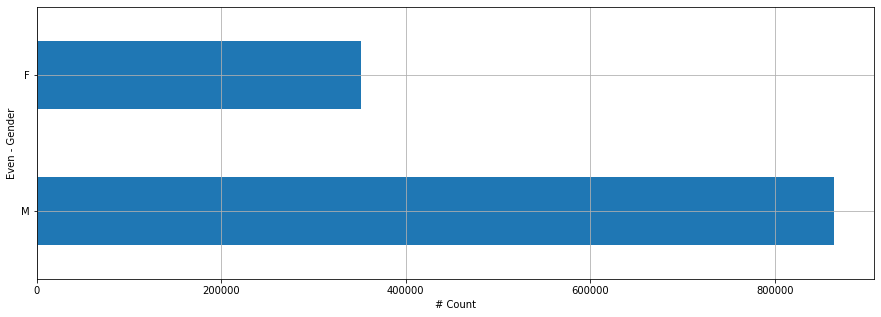

time: 879 ms (started: 2023-02-04 09:56:34 +00:00)


In [21]:
# Gender Value Counts
plt.figure(figsize=(15,5))
selected_df.collect(streaming=True).to_pandas()["gender"].value_counts().plot(kind='barh', grid=True)
plt.xlabel("# Count")
plt.ylabel("Even - Gender")

In [22]:
# Querying for required column(s)
selected_df = non_event_data_df.select(
    [
        pl.col("gender"),
    ]
)
selected_df.collect(streaming=True).to_pandas()["gender"].value_counts()

M    47904
F    26741
Name: gender, dtype: int64

time: 24.5 ms (started: 2023-02-04 09:56:35 +00:00)


Text(0, 0.5, 'Non Event - Gender')

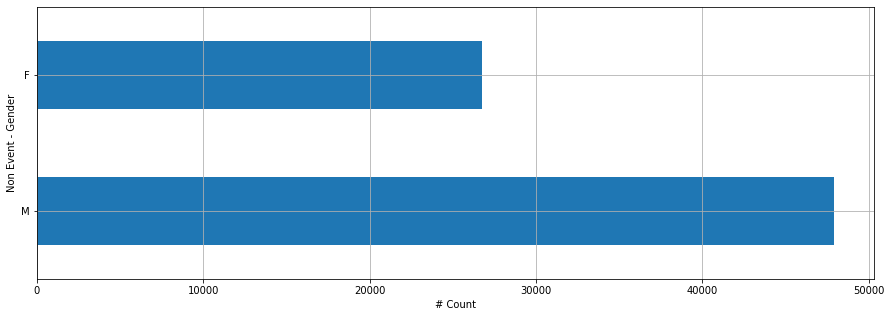

time: 229 ms (started: 2023-02-04 09:56:35 +00:00)


In [23]:
# Gender Value Counts
plt.figure(figsize=(15,5))
selected_df.collect(streaming=True).to_pandas()["gender"].value_counts().plot(kind='barh', grid=True)
plt.xlabel("# Count")
plt.ylabel("Non Event - Gender")

Text(0, 0.5, 'Event - Age')

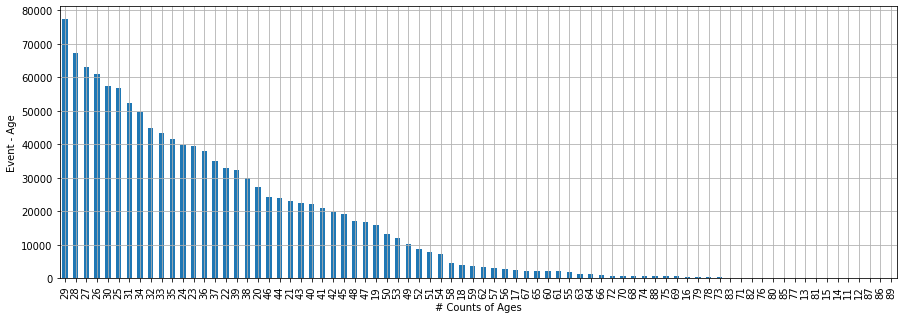

time: 1.7 s (started: 2023-02-04 09:56:35 +00:00)


In [24]:
# Age Value Counts

# Querying for required column(s)
selected_df = event_data_df.select(
    [
        pl.col("age"),
    ]
)

plt.figure(figsize=(15,5))
selected_df.collect(streaming=True).to_pandas()["age"].value_counts().plot(kind='bar', grid=True)
plt.xlabel("# Counts of Ages")
plt.ylabel("Event - Age")

Text(0, 0.5, 'Non Event - Age')

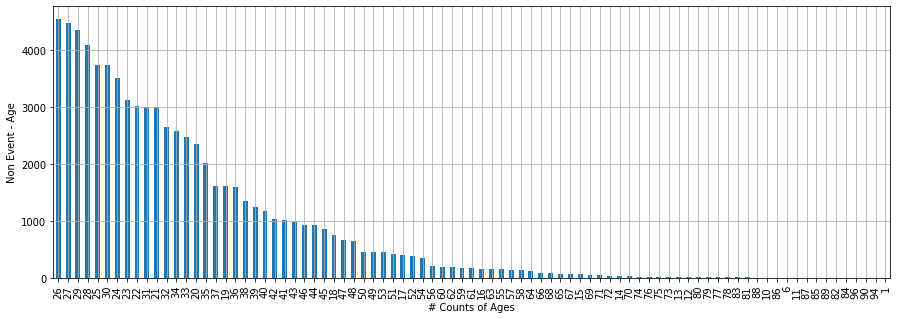

time: 1.23 s (started: 2023-02-04 09:56:37 +00:00)


In [25]:
# Age Value Counts

# Querying for required column(s)
selected_df = non_event_data_df.select(
    [
        pl.col("age"),
    ]
)

plt.figure(figsize=(15,5))
selected_df.collect(streaming=True).to_pandas()["age"].value_counts().plot(kind='bar', grid=True)
plt.xlabel("# Counts of Ages")
plt.ylabel("Non Event - Age")

In [26]:
# Deleting `temp` variable(s) and running garbage collection.
del selected_df
gc.collect()

108

time: 133 ms (started: 2023-02-04 09:56:38 +00:00)


#### 2. Boxplot analysis for gender and age [bivariate].

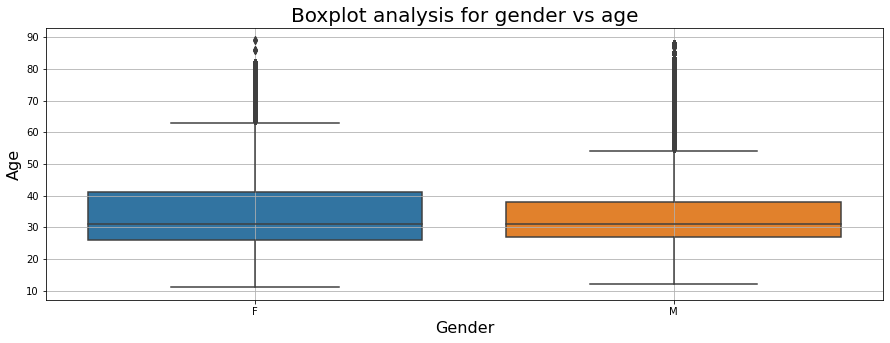

time: 936 ms (started: 2023-02-04 09:56:38 +00:00)


In [27]:
# Querying for required column(s)
selected_df = event_data_df.select(
    [
        pl.col("gender"),
        pl.col("age"),
    ]
)

plt.figure(figsize=(15,5))
selected_df_pd = selected_df.collect(streaming=True).to_pandas()
sns.boxplot(data=selected_df_pd, x='gender', y='age')
plt.grid()
plt.title("Boxplot analysis for gender vs age", fontsize=20)      
plt.xlabel("Gender", fontsize=16)
plt.ylabel("Age", fontsize=16)
plt.show()

In [28]:
# Deleting `temp` variable(s) and running garbage collection.
del selected_df
del selected_df_pd
gc.collect()

3192

time: 116 ms (started: 2023-02-04 09:56:39 +00:00)


#### 3. Plot the percentage of the device_ids with and without event data

In [29]:
# Querying for required column(s)
temp_event_df = event_data_df.filter(pl.col("event_id") != None)
temp_event_df = temp_event_df.select(
    [
        pl.col("device_id").unique().alias("device_id"),
    ]
)
temp_non_event_df = non_event_data_df.select(
    [
        pl.col("device_id"),
        pl.col("device_id").is_in(temp_event_df.collect(streaming=True)["device_id"]).alias("has_event"),
    ]
)

time: 685 ms (started: 2023-02-04 09:56:39 +00:00)


In [30]:
temp_non_event_df.groupby(by='has_event').agg(pl.count()).collect(streaming=True).to_pandas()

,has_event,count
0,False,51335
1,True,23310


time: 49.1 ms (started: 2023-02-04 09:56:40 +00:00)


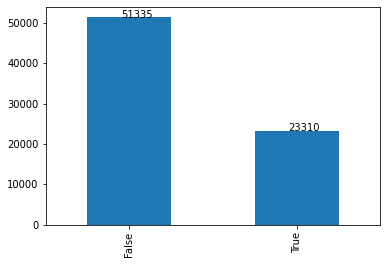

time: 259 ms (started: 2023-02-04 09:56:40 +00:00)


In [31]:
# Creating a countplot for question 3
ax = temp_non_event_df.collect(streaming=True).to_pandas().has_event.value_counts().plot(kind='bar')

for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x()+0.2, p.get_height()))

plt.show()

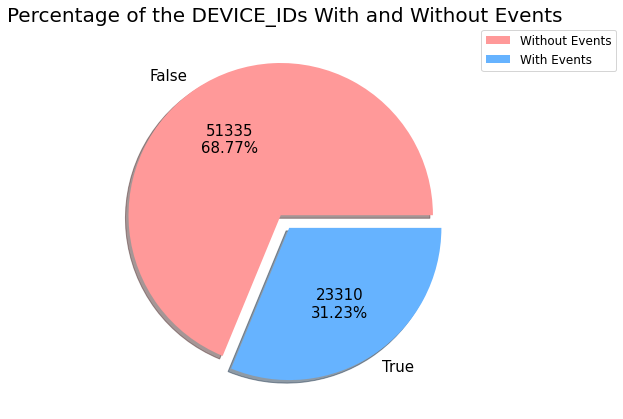

time: 251 ms (started: 2023-02-04 09:56:41 +00:00)


In [32]:
def label_function(val):
    return f'{val / 100 * len(temp_non_event_df.collect().to_pandas()):.0f}\n{val:.2f}%'

fig, ax = plt.subplots(ncols=1, figsize=(15, 7))

temp_non_event_df.collect(streaming=True).to_pandas().groupby('has_event') \
                    .size().plot(kind='pie', 
                                 autopct=label_function, 
                                 textprops={'fontsize': 15},
                                 colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'], 
                                 explode=[0.05, 0.05],
                                 shadow=True,
                                 ax=ax)
ax.legend(['Without Events', 'With Events'], 
          loc='best', 
          bbox_to_anchor=(1, 1.02), 
          fontsize='large')
ax.set_title("Percentage of the DEVICE_IDs With and Without Events", fontsize=20, pad=10)
plt.ylabel("")

plt.show()

In [33]:
# Deleting `temp` variable(s) and running garbage collection.
del temp_event_df
del temp_non_event_df
gc.collect()

0

time: 156 ms (started: 2023-02-04 09:56:41 +00:00)


#### 4. Plot a graph representing the distribution of events over different days of a week.

In [34]:
day_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
event_data_df = event_data_df.select(
    [
        pl.col("*"),
        pl.col("time_stamp").dt.day().alias("day"),
        pl.col("time_stamp").dt.weekday().apply(lambda x: day_names[x-1]).alias("weekday"),
        pl.col("time_stamp").dt.month().alias("month"),
        pl.col("time_stamp").dt.hour().alias("hour"),
    ]
)

age_cat_df = pl.cut(event_data_df.collect(streaming=True)['age'], 
                     bins=[0, 24, 32, 45, 100], 
                     labels=["LOW", "0-24", "25-32", "33-45", "46+", "HIGH"])
age_cat_df = age_cat_df.select(pl.col('category').cast(pl.Utf8))
age_cat_df = age_cat_df.rename({'category': 'age_cat'})

event_data_df = event_data_df.with_column(age_cat_df['age_cat'])


time: 2.63 s (started: 2023-02-04 09:56:41 +00:00)


In [35]:
event_data_df.head().collect(streaming=True)

device_id,gender,age,group_train,event_id,time_stamp,longitude,latitude,day,weekday,month,hour,age_cat
i64,cat,i8,cat,i32,datetime[ns],f32,f32,u32,str,u32,u32,str
-1001337759327040000,"""M""",30,"""M25-32""",2774404,2016-05-07 09:14:24,119.610001,29.700001,7,"""Saturday""",5,9,"""0-24"""
-1001337759327040000,"""M""",30,"""M25-32""",3065018,2016-05-04 10:26:14,120.290001,30.42,4,"""Wednesday""",5,10,"""0-24"""
-1001337759327040000,"""M""",30,"""M25-32""",3230344,2016-05-04 10:04:42,120.300003,30.41,4,"""Wednesday""",5,10,"""0-24"""
-1001337759327040000,"""M""",30,"""M25-32""",2906128,2016-05-07 10:24:32,119.690002,29.799999,7,"""Saturday""",5,10,"""0-24"""
-1001337759327040000,"""M""",30,"""M25-32""",2876843,2016-05-07 10:23:56,119.690002,29.799999,7,"""Saturday""",5,10,"""0-24"""


time: 2.1 s (started: 2023-02-04 09:56:44 +00:00)


In [36]:
# Querying for required column(s)
day_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
temp_event_df = event_data_df.filter(pl.col("weekday") != None) \
                                .groupby(by='weekday').agg(pl.col('device_id').count() \
                                    .alias('device_id_count'))   

time: 21.2 ms (started: 2023-02-04 09:56:46 +00:00)


In [37]:
print(temp_event_df.collect(streaming=True))

shape: (7, 2)
┌───────────┬─────────────────┐
│ weekday   ┆ device_id_count │
│ ---       ┆ ---             │
│ str       ┆ u32             │
╞═══════════╪═════════════════╡
│ Wednesday ┆ 178371          │
│ Tuesday   ┆ 180296          │
│ Saturday  ┆ 166835          │
│ Friday    ┆ 176657          │
│ Sunday    ┆ 164017          │
│ Monday    ┆ 169381          │
│ Thursday  ┆ 180041          │
└───────────┴─────────────────┘
time: 2.18 s (started: 2023-02-04 09:56:46 +00:00)


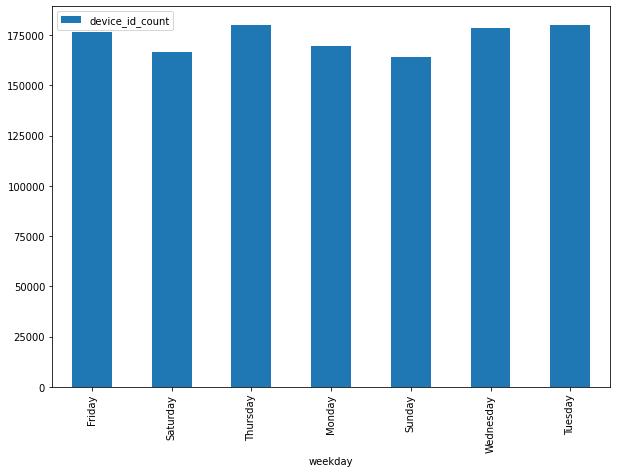

time: 2.84 s (started: 2023-02-04 09:56:48 +00:00)


In [38]:
temp_event_df.collect(streaming=True).to_pandas().plot.bar(x='weekday', y='device_id_count', figsize=(10, 7))
plt.show()

It seems that most events are happening on Tuesday, Wednesday, and Thursday whereas the least events are happening on Sunday.

In [39]:
# Deleting `temp` variable(s) and running garbage collection.
del temp_event_df
gc.collect()

3021

time: 153 ms (started: 2023-02-04 09:56:51 +00:00)


#### 5. Plot a graph representing the distribution of events per hour [for one-week data]

In [40]:
# Filtering and getting one week data
from datetime import datetime

one_week_data_df = event_data_df.filter(pl.col("time_stamp").is_between(datetime(2016, 5, 1), 
                                                                        datetime(2016, 5, 8)))

time: 2.81 ms (started: 2023-02-04 09:56:51 +00:00)


In [41]:
print(f"Length of One Week DF: {len(one_week_data_df.collect(streaming=True))}")
print(f"Length of Entire DF: {len(event_data_df.collect(streaming=True))}")

Length of One Week DF: 1215219
Length of Entire DF: 1215598
time: 4.16 s (started: 2023-02-04 09:56:51 +00:00)


Almost all events have happened in the first week of May 2016. Continuing to find the hourly events

In [42]:
# Querying for required column(s)
temp_one_week_df = one_week_data_df.select(
    [
        pl.col('gender'),
        pl.col('age_cat'),
        pl.col('weekday'),
        pl.col('hour'),
    ]
)
temp_one_week_df_pd = temp_one_week_df.collect(streaming=True).to_pandas()

time: 2.12 s (started: 2023-02-04 09:56:55 +00:00)


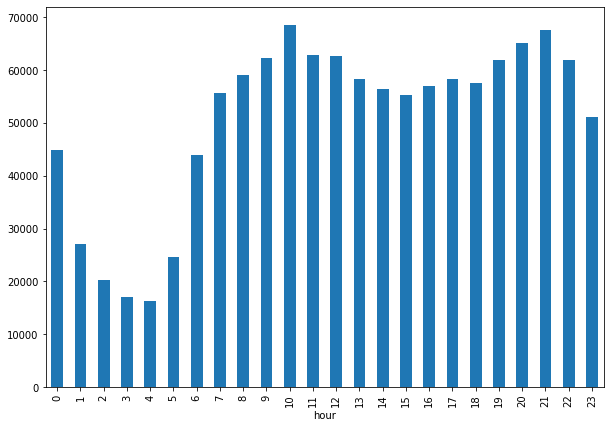

time: 353 ms (started: 2023-02-04 09:56:57 +00:00)


In [43]:
temp_one_week_df_pd.groupby('hour').size().plot(kind='bar',
                                                figsize=(10, 7))
plt.show()

The above graph shows that the maximum events occurred at 10 am in the morning and 9 pm in the event while the least events happened at 3 am and 4 am. Overall a lot of events happened at all times except between 1-5 am.

#### 6.The difference in the distribution of events per hour for Male and Female consumers. [Show the difference using an appropriate chart for one-week data.]

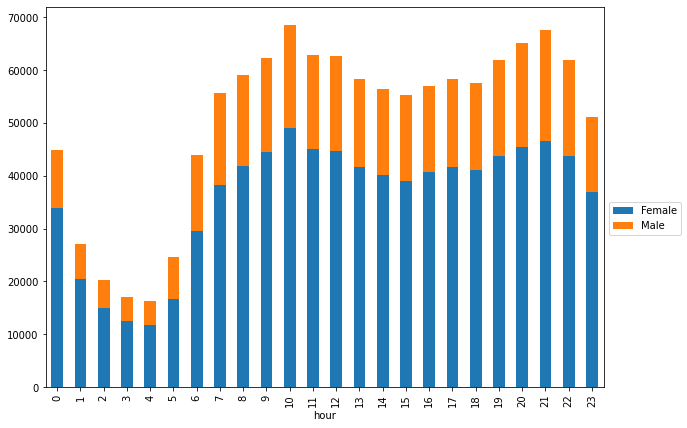

time: 888 ms (started: 2023-02-04 09:56:58 +00:00)


In [44]:
temp_one_week_df_pd.groupby('hour')['gender'].value_counts().unstack().plot(kind='bar',
                                                                            stacked=True,
                                                                            figsize=(10, 7))
plt.legend(["Female", "Male"], loc='best', bbox_to_anchor=(1, 0.5))
plt.show()

Overall, men seem to be using phones more at late nights compared to women.

#### 7.Is there any difference in the distribution of Events for different Age Groups over different days of the week? [Consider the following age groups: 0–24, 25–32, 33–45, and 46+]

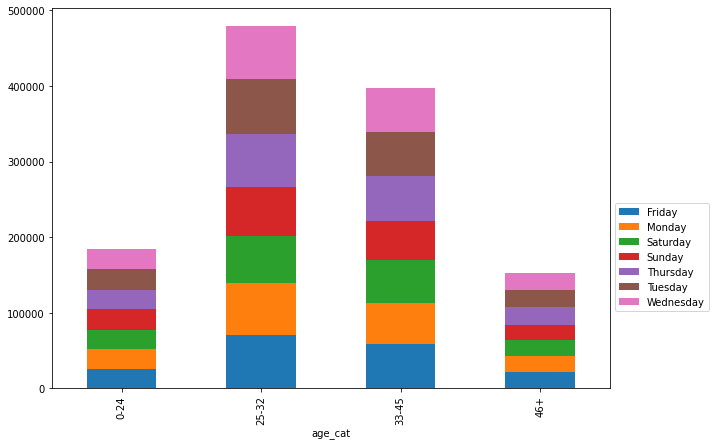

time: 581 ms (started: 2023-02-04 09:56:59 +00:00)


In [45]:
temp_one_week_df_pd.groupby('age_cat')['weekday'].value_counts() \
                    .unstack().plot(kind='bar', stacked=True, figsize=(10, 7))
plt.legend(loc='best', bbox_to_anchor=(1, 0.5))
plt.show()

From the above data we can only tell that Males overall access phones a lot compared to females. Both 32+ males and females access phones a lot on all days.

In [46]:
# Deleting `temp` variable(s) and running garbage collection.
del temp_one_week_df
del temp_one_week_df_pd
gc.collect()

16555

time: 130 ms (started: 2023-02-04 09:56:59 +00:00)


#### 8.Stacked bar chart for the top 10 mobile brands across male and female consumers.

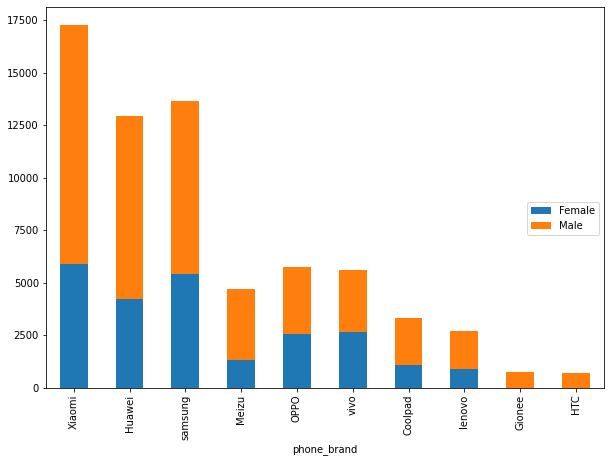

time: 378 ms (started: 2023-02-04 09:56:59 +00:00)


In [47]:
# Querying for required column(s)
temp_non_event_df = non_event_data_df.select(
    [
        pl.col('gender').alias('gender'),
        pl.col('phone_brand').alias('phone_brand'),
    ]
)
temp_non_event_df.collect(streaming=True).to_pandas().groupby('phone_brand')['gender'] \
                    .value_counts().sort_values(ascending=False).head(18) \
                        .unstack().plot(kind='bar', stacked=True, figsize=(10, 7))
plt.legend(["Female", "Male"], loc='best', bbox_to_anchor=(1, 0.5))
plt.show()

The above graph shows that overall there are more male customers than female in the top 10 brands.

In [48]:
# Deleting `temp` variable(s) and running garbage collection.
del temp_non_event_df
gc.collect()

4115

time: 97.5 ms (started: 2023-02-04 09:57:00 +00:00)


#### 9. Prepare a chart representing the ten frequently used applications and their respective male and female percentage.

In [49]:
event_app_data_df = event_data_df.join(app_data_df, on='event_id')

time: 684 µs (started: 2023-02-04 09:57:00 +00:00)


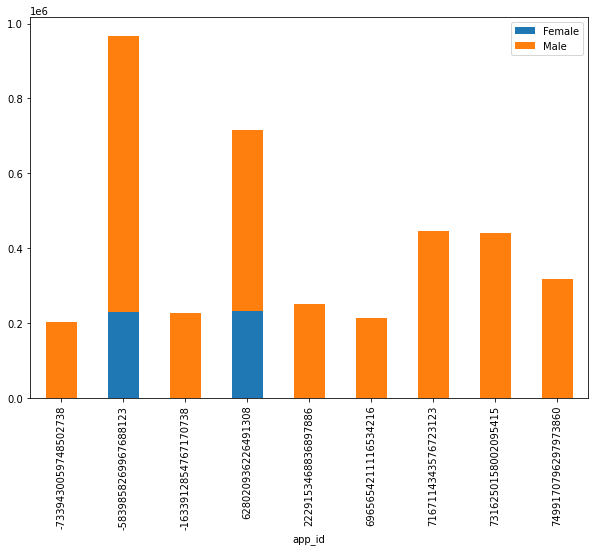

time: 14.6 s (started: 2023-02-04 09:57:00 +00:00)


In [50]:
# Querying for required column(s)
temp_event_app_data_df = event_app_data_df.select(
    [
        pl.col('app_id'),
        pl.col('gender'),
    ]
)

temp_df_pd = temp_event_app_data_df.groupby(by=['app_id', 'gender']) \
                                    .agg(pl.col('gender').count().alias('gender_count')) \
                                    .sort(by='gender_count', reverse=True) \
                                    .head(11).collect().to_pandas()
                                
pd.pivot_table(data=temp_df_pd, 
               index=['app_id'], 
               columns=['gender'], 
               values='gender_count') \
                    .plot.bar(stacked=True, 
                              figsize=(10, 7))
plt.legend(["Female", "Male"], loc='best')
plt.show()

The above graph tells us that barring the app with the highest users, the other top 10 apps are all mostly used by males

In [51]:
# Deleting `temp` variable(s) and running garbage collection.
del event_app_data_df
del temp_event_app_data_df
del temp_df_pd
gc.collect()

3751

time: 97.1 ms (started: 2023-02-04 09:57:15 +00:00)


#### 10. List the top 10 mobile phone brands bought by customers by age groups. [Consider the following age groups: 0–24, 25–32, 33–45, and 46+]

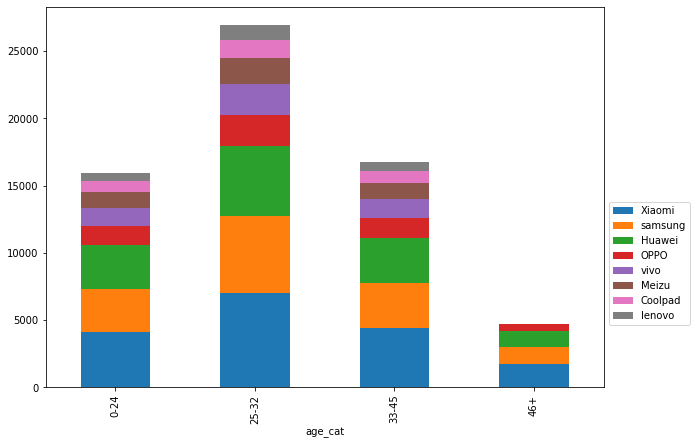

time: 301 ms (started: 2023-02-04 09:57:15 +00:00)


In [52]:
# Querying for required column(s)
age_cat_df = pl.cut(non_event_data_df.collect(streaming=True)['age'], 
                     bins=[0, 24, 32, 45, 100], 
                     labels=["LOW", "0-24", "25-32", "33-45", "46+", "HIGH"])
age_cat_df = age_cat_df.select(pl.col('category').cast(pl.Utf8))
age_cat_df = age_cat_df.rename({'category':'age_cat'})

non_event_data_df = non_event_data_df.with_column(age_cat_df['age_cat'])


temp_non_event_data_df = non_event_data_df.select(
    [
        pl.col('age'),
        pl.col('phone_brand'),
        pl.col('age_cat').cast(pl.Utf8),
    ]
)

temp_non_event_data_df.collect(streaming=True).to_pandas().groupby('age_cat')['phone_brand'] \
                        .value_counts().sort_values(ascending=False).head(28) \
                            .unstack().plot(kind='bar',
                                            stacked=True, 
                                            figsize=(10, 7))
plt.legend(loc='best', bbox_to_anchor=(1, 0.5))
plt.show()

In [53]:
# Deleting `temp` variable(s) and running garbage collection.
del age_cat_df
del temp_non_event_data_df
gc.collect()

5172

time: 94.7 ms (started: 2023-02-04 09:57:15 +00:00)


Overall the observation is that Xiaomi is the most preferred brand across all categories.

## Geo-Spatial Visualisation

### Plot the visualisation plot for a sample of 1 lakh data points

In [54]:
from mpl_toolkits.basemap import Basemap
%matplotlib inline

time: 129 ms (started: 2023-02-04 09:57:15 +00:00)


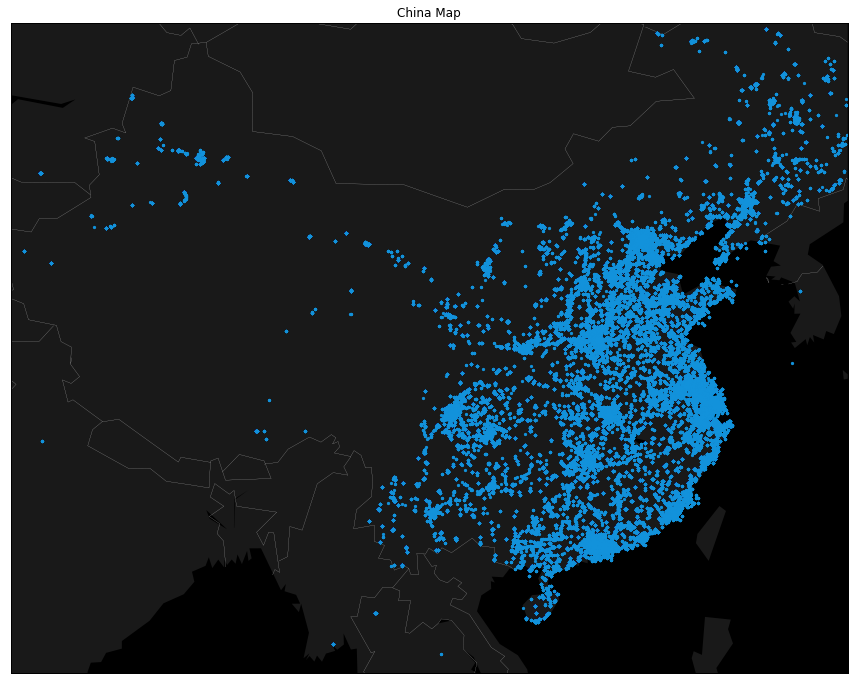

In [55]:
sample_event_data_df = event_data_df.collect(streaming=True)#.fetch(n_rows=100000)
sample_event_data_df_pd = sample_event_data_df.to_pandas()

fig = plt.figure(figsize=(15, 15))

# Mercator of World
m = Basemap(projection='merc',
             llcrnrlat=15,  #latitude of lower left hand corner of the desired map domain
             urcrnrlat=50, #latitude of upper right hand corner of the desired map domain
             llcrnrlon=75, #longitude of lower left hand corner of the desired map domain
             urcrnrlon=130, #longitude of upper right hand corner of the desired map domain
             lat_ts=0, #latitude of true scale
             resolution='c') #resolution of boundary dataset being used - c for crude


m.fillcontinents(color='#191919',lake_color='#000000') # dark grey land, black lakes
m.drawmapboundary(fill_color='#000000')                # black background
m.drawcountries(linewidth=0.15, color="w")              # thin white line for country borders

# Plot the data
mxy = m(sample_event_data_df_pd["longitude"].tolist(), 
        sample_event_data_df_pd["latitude"].tolist())
m.scatter(mxy[0], mxy[1], s=5, c="#1292db", zorder=2)    # zorder for the points  

plt.title("China Map")
plt.show()

In [56]:
# Deleting `temp` variable(s) and running garbage collection.
# del sample_event_data_df
del sample_event_data_df_pd
gc.collect()

4

time: 6.34 s (started: 2023-02-04 09:57:15 +00:00)
time: 132 ms (started: 2023-02-04 09:57:22 +00:00)


The above map shows that most of the data points are concentrated in China.

### Compare the event visualisation plots based on the users' gender information. [This can be done on the sample of 1 lakh data points.]

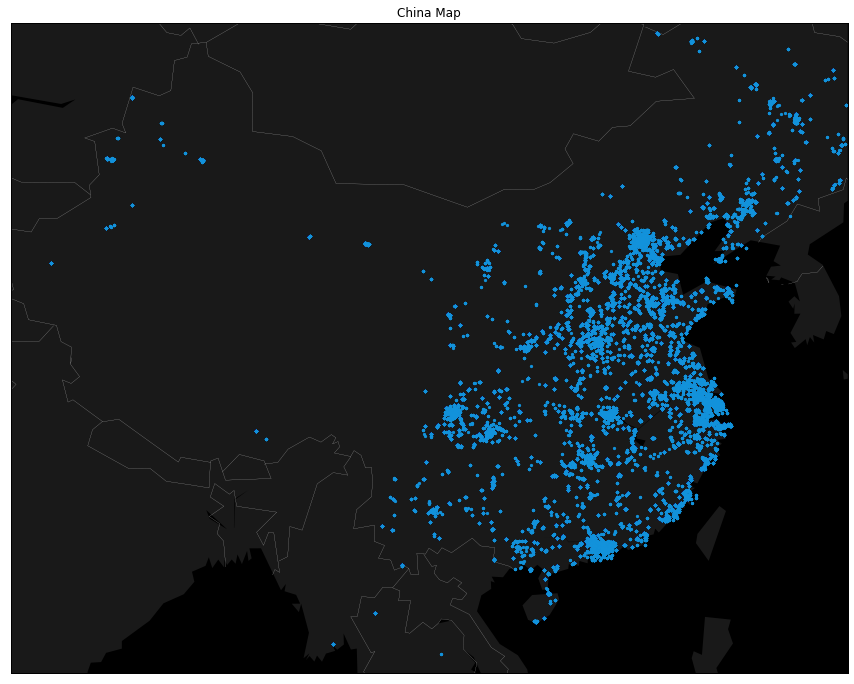

time: 2.58 s (started: 2023-02-04 09:57:22 +00:00)


In [57]:
sample_event_data_F_df = event_data_df.filter(pl.col('gender')=="F").collect(streaming=True)#.fetch(n_rows=100000)
sample_event_data_F_df_pd = sample_event_data_F_df.to_pandas()

fig = plt.figure(figsize=(15, 15))

# Mercator of World
m = Basemap(projection='merc',
             llcrnrlat=15,  #latitude of lower left hand corner of the desired map domain
             urcrnrlat=50, #latitude of upper right hand corner of the desired map domain
             llcrnrlon=75, #longitude of lower left hand corner of the desired map domain
             urcrnrlon=130, #longitude of upper right hand corner of the desired map domain
             lat_ts=0, #latitude of true scale
             resolution='c') #resolution of boundary dataset being used - c for crude


m.fillcontinents(color='#191919',lake_color='#000000') # dark grey land, black lakes
m.drawmapboundary(fill_color='#000000')                # black background
m.drawcountries(linewidth=0.15, color="w")              # thin white line for country borders

# Plot the data
mxy = m(sample_event_data_F_df_pd["longitude"].tolist(), 
        sample_event_data_F_df_pd["latitude"].tolist())
m.scatter(mxy[0], mxy[1], s=5, c="#1292db", zorder=2)    # zorder for the points  

plt.title("China Map")
plt.show()

In [58]:
# Deleting `temp` variable(s) and running garbage collection.
del sample_event_data_F_df
del sample_event_data_F_df_pd
gc.collect()

2337

time: 114 ms (started: 2023-02-04 09:57:24 +00:00)


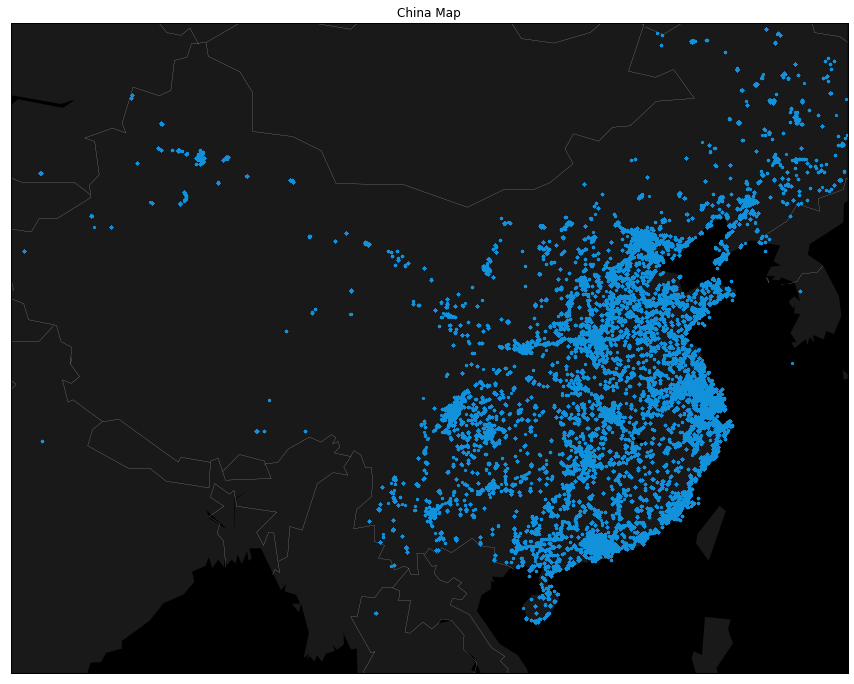

time: 4.78 s (started: 2023-02-04 09:57:24 +00:00)


In [59]:
sample_event_data_M_df = event_data_df.filter(pl.col('gender')=="M").collect(streaming=True)#.fetch(n_rows=100000)
sample_event_data_M_df_pd = sample_event_data_M_df.to_pandas()

fig = plt.figure(figsize=(15, 15))

# Mercator of World
m = Basemap(projection='merc',
             llcrnrlat=15,  #latitude of lower left hand corner of the desired map domain
             urcrnrlat=50, #latitude of upper right hand corner of the desired map domain
             llcrnrlon=75, #longitude of lower left hand corner of the desired map domain
             urcrnrlon=130, #longitude of upper right hand corner of the desired map domain
             lat_ts=0, #latitude of true scale
             resolution='c') #resolution of boundary dataset being used - c for crude


m.fillcontinents(color='#191919',lake_color='#000000') # dark grey land, black lakes
m.drawmapboundary(fill_color='#000000')                # black background
m.drawcountries(linewidth=0.15, color="w")              # thin white line for country borders

# Plot the data
mxy = m(sample_event_data_M_df_pd["longitude"].tolist(), 
        sample_event_data_M_df_pd["latitude"].tolist())
m.scatter(mxy[0], mxy[1], s=5, c="#1292db", zorder=2)    # zorder for the points  

plt.title("China Map")
plt.show()

In [60]:
# Deleting `temp` variable(s) and running garbage collection.
del sample_event_data_M_df
del sample_event_data_M_df_pd
gc.collect()

2337

time: 130 ms (started: 2023-02-04 09:57:29 +00:00)


Can't say much based on the gender information except that the number of points for males are more than that of females.

### Compare the event visualisation plots based on the age groups

- 0–24 

- 25–32

- 32+

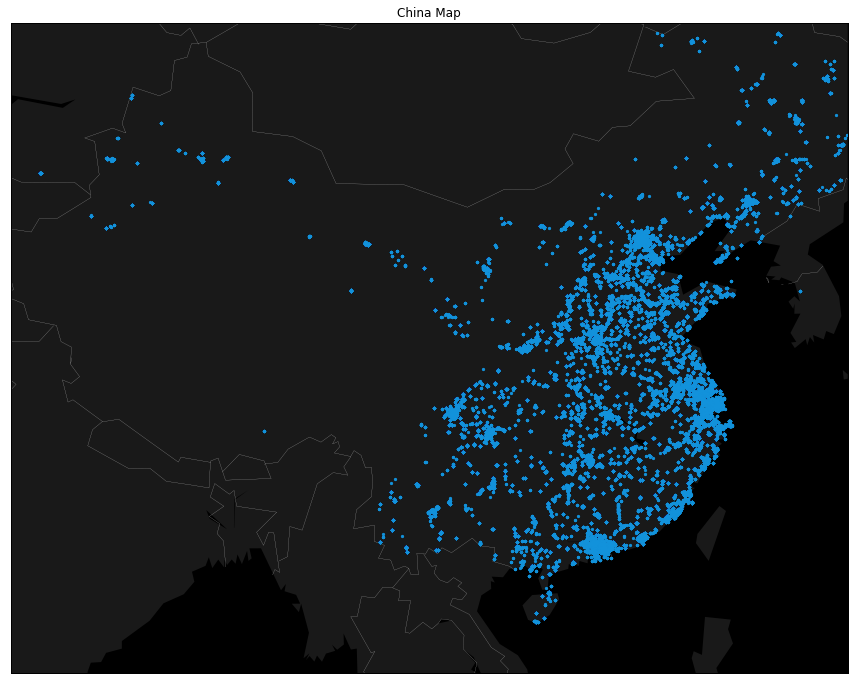

time: 3.39 s (started: 2023-02-04 09:57:29 +00:00)


In [61]:
sample_df = event_data_df.filter((pl.col('group_train') == "M32+") | 
                                 (pl.col('group_train') == "F32+")) \
                            .collect(streaming=True)#.fetch(n_rows=100000)
sample_df_pd = sample_df.to_pandas()

fig = plt.figure(figsize=(15, 15))

# Mercator of World
m = Basemap(projection='merc',
             llcrnrlat=15,  #latitude of lower left hand corner of the desired map domain
             urcrnrlat=50, #latitude of upper right hand corner of the desired map domain
             llcrnrlon=75, #longitude of lower left hand corner of the desired map domain
             urcrnrlon=130, #longitude of upper right hand corner of the desired map domain
             lat_ts=0, #latitude of true scale
             resolution='c') #resolution of boundary dataset being used - c for crude


m.fillcontinents(color='#191919',lake_color='#000000') # dark grey land, black lakes
m.drawmapboundary(fill_color='#000000')                # black background
m.drawcountries(linewidth=0.15, color="w")              # thin white line for country borders

# Plot the data
mxy = m(sample_df_pd["longitude"].tolist(), sample_df_pd["latitude"].tolist())
m.scatter(mxy[0], mxy[1], s=5, c="#1292db", zorder=2)    # zorder for the points  

plt.title("China Map")
plt.show()

In [62]:
# Deleting `temp` variable(s) and running garbage collection.
del sample_df
del sample_df_pd
gc.collect()

2315

time: 122 ms (started: 2023-02-04 09:57:33 +00:00)


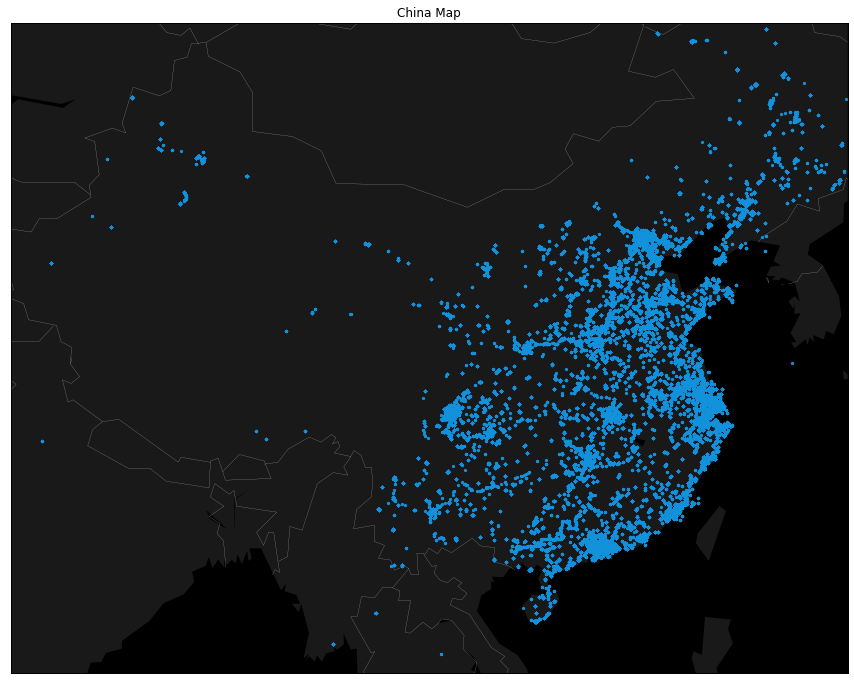

time: 3.18 s (started: 2023-02-04 09:57:33 +00:00)


In [63]:
sample_df = event_data_df.filter((pl.col('group_train') == "M25-32") | 
                                 (pl.col('group_train') == "F25-32")) \
                            .collect(streaming=True)#.fetch(n_rows=100000)
sample_df_pd = sample_df.to_pandas()

fig = plt.figure(figsize=(15, 15))

# Mercator of World
m = Basemap(projection='merc',
             llcrnrlat=15,  #latitude of lower left hand corner of the desired map domain
             urcrnrlat=50, #latitude of upper right hand corner of the desired map domain
             llcrnrlon=75, #longitude of lower left hand corner of the desired map domain
             urcrnrlon=130, #longitude of upper right hand corner of the desired map domain
             lat_ts=0, #latitude of true scale
             resolution='c') #resolution of boundary dataset being used - c for crude


m.fillcontinents(color='#191919',lake_color='#000000') # dark grey land, black lakes
m.drawmapboundary(fill_color='#000000')                # black background
m.drawcountries(linewidth=0.15, color="w")              # thin white line for country borders

# Plot the data
mxy = m(sample_df_pd["longitude"].tolist(), sample_df_pd["latitude"].tolist())
m.scatter(mxy[0], mxy[1], s=5, c="#1292db", zorder=2)    # zorder for the points  

plt.title("China Map")
plt.show()

In [64]:
# Deleting `temp` variable(s) and running garbage collection.
del sample_df
del sample_df_pd
gc.collect()

2337

time: 117 ms (started: 2023-02-04 09:57:36 +00:00)


## Feature Engineering

### Feature Engineering on Events data

#### 1. Considering the events data, you can create a feature called Average Events, which can give you an estimate of how long the users' mobile phones are active.

In [65]:
# Querying for required column(s)
selected_features_df = event_data_df.select(
    [
        pl.col('device_id'),
        pl.col('event_id'),
    ]
)

unique_device_count = len(event_data_df.select([pl.col('device_id')]).unique().collect())

selected_features_df = selected_features_df.groupby('device_id') \
                                           .agg([pl.col('event_id').count()/unique_device_count])
selected_features_df = selected_features_df.rename({'event_id': 'device_avg_events'})

event_data_df = event_data_df.join(selected_features_df, on='device_id')

# event_data_df = event_data_df.collect(streaming=True).lazy()

time: 285 ms (started: 2023-02-04 09:57:36 +00:00)


In [66]:
# Deleting `temp` variable(s) and running garbage collection.
del selected_features_df
gc.collect()

0

time: 109 ms (started: 2023-02-04 09:57:37 +00:00)


#### 2. You can use the information related to the location of the users (latitude and longitude data) to create features representing changes in the latitude and longitude details at different times of the day.

In [67]:
# Querying for required column(s)
selected_features_df = event_data_df.select(
    [
        pl.col('device_id'),
        pl.col('latitude'),
    ]
)

selected_features_df = selected_features_df.groupby('device_id').agg([pl.col('latitude').count()])
selected_features_df = selected_features_df.rename({'latitude': 'lat_long_count'})

event_data_df = event_data_df.join(selected_features_df, on='device_id')

# event_data_df = event_data_df.collect(streaming=True).lazy()

time: 1.58 ms (started: 2023-02-04 09:57:37 +00:00)


In [68]:
# Deleting `temp` variable(s) and running garbage collection.
del selected_features_df
gc.collect()

0

time: 108 ms (started: 2023-02-04 09:57:37 +00:00)


#### 3. You can create features such as Median Latitude and Median Longitude for different event ids.

In [69]:
# Querying for required column(s)
selected_features_df = event_data_df.select(
    [
        pl.col('device_id'),
        pl.col('latitude'),
        pl.col('longitude'),
    ]
)

median_lat_df = selected_features_df.groupby('device_id').agg([pl.col('latitude').median()])
median_lat_df = median_lat_df.rename({'latitude': 'device_median_latitude'})

median_long_df = selected_features_df.groupby('device_id').agg([pl.col('longitude').median()])
median_long_df = median_long_df.rename({'longitude': 'device_median_longitude'})

event_data_df = event_data_df.join(median_lat_df, on='device_id')
event_data_df = event_data_df.join(median_long_df, on='device_id')

# event_data_df = event_data_df.collect(streaming=True).lazy()

time: 2.99 ms (started: 2023-02-04 09:57:37 +00:00)


In [70]:
# Deleting `temp` variable(s) and running garbage collection.
del selected_features_df
gc.collect()

0

time: 107 ms (started: 2023-02-04 09:57:37 +00:00)


#### Creating a new column for hour category

In [71]:
hour_cat_df = pl.cut(event_data_df.collect(streaming=True)["hour"],
                     bins=[-1, 3, 6, 11, 15, 20, 24],
                     labels=["LOW", "Late Night", "Early Morning", "Morning", 
                             "Afternoon", "Evening", "Night", "HIGH"])

hour_cat_df = hour_cat_df.select(pl.col('category').cast(pl.Utf8))
hour_cat_df = hour_cat_df.rename({'category': 'hour_cat'})

event_data_df = event_data_df.with_column(hour_cat_df['hour_cat'])

time: 3.13 s (started: 2023-02-04 09:57:37 +00:00)


In [72]:
device_best_hour_df = event_data_df.groupby(by='device_id') \
                            .agg(pl.col('hour_cat').max().alias('device_best_hour'))

time: 911 µs (started: 2023-02-04 09:57:40 +00:00)


#### Creating a new column for best day for a device

In [73]:
device_best_day_df = event_data_df.groupby(by='device_id') \
                                .agg(pl.col('weekday').max().alias('device_best_day'))

time: 914 µs (started: 2023-02-04 09:57:40 +00:00)


### Feature Engineering on AppData

#### 4. You can also group the existing categories to create a new supercategory that will establish a significance in predicting the outcome variable.

In [74]:
def replace(column: str, mapping: dict) -> pl.Expr:
    if not mapping:
        raise Exception("Mapping can't be empty")
    elif not isinstance(mapping, dict):
        TypeError(f"mapping must be of type dict, but is type: {type(mapping)}")
    if not isinstance(column, str):
        raise TypeError(f"column must be of type str, but is type: {type(column)}")

    branch = pl.when(pl.col(column).str.to_lowercase().str.contains('|'.join(list(mapping.values())[0]))) \
                    .then(list(mapping.keys())[0])

    for to_value, from_value in mapping.items():
        branch = branch.when(pl.col(column).str.to_lowercase().str.contains('|'.join(from_value))).then(to_value)

    return branch.otherwise("Other").alias(column)


time: 1.73 ms (started: 2023-02-04 09:57:40 +00:00)


In [75]:
from_ = [["game", "free", "video", "fun", "lottery", "puzzle"], 
         ["community", "property"],
         ["joke", "comic", "passion", "lottery", "news", "music", "photo", "dance", "radio", "film"], 
         ["exercise", "parent", "baby", "child", "maternal", "insurance", "personal", "medical", "sport", "gym"], 
         ["equity", "broker", "card", "business", "industry", "job", "shares", "stock", "fund", "profit", "account", 
          "bank", "financ", "loan", "p2p", "Pay", "risk", "income", "debit", "credit", "securit"],
         ["recipe", "japan", "korea", "takeaway", "order"], 
         ["shop", "fashion", "cozy", "trend"], 
         ["church", "service"],
         ["aviation", "housing", "car", "train", "tour", "travel", "custom", "taxi", "book", "map"]]
to_ = ["Games", "Real Estate", "Entertainment", "Health", "Finance", "Food", "Shopping", "Religion", "Travel"]

from_to_mapping = {}
for from_val, to_val in zip(from_, to_):
    from_to_mapping[to_val] = from_val

time: 1.74 ms (started: 2023-02-04 09:57:40 +00:00)


In [76]:
# Querying for required column(s)
app_data_df = app_data_df.select(
    [
        pl.col('*'),
        pl.col('category').alias('super_category'),
    ]
)
    
app_data_df = app_data_df.with_column(replace('super_category', from_to_mapping))

time: 1.78 ms (started: 2023-02-04 09:57:40 +00:00)


In [77]:
# sample_app_df.head()
app_data_df.head().fetch(n_rows=5, streaming=True)

event_id,app_id,is_installed,is_active,label_id,category,super_category
i32,i64,i8,i8,i16,str,str
186389,-1002609068504196793,1,0,859,"""pursue""","""Other"""
63574,-1002609068504196793,1,0,859,"""pursue""","""Other"""
123050,-1002609068504196793,1,0,859,"""pursue""","""Other"""
2909,-1002609068504196793,1,0,859,"""pursue""","""Other"""
3090353,-1002609068504196793,1,0,859,"""pursue""","""Other"""


time: 5min 8s (started: 2023-02-04 09:57:40 +00:00)


In [78]:
# Deleting `temp` variable(s) and running garbage collection.
gc.collect()

0

time: 137 ms (started: 2023-02-04 10:02:49 +00:00)


## DBScan Clustering 

In [79]:
# coords_df = event_data_df.select(
#     [
#         pl.col('latitude').alias('lat'),
#         pl.col('longitude').alias('lon'),
#     ]
# ).filter(
#     ((pl.col('lat') < -1) | (pl.col('lat') > 1)) & \
#         ((pl.col('lon') < -1) | (pl.col('lon') > 1)) 
# )

time: 396 µs (started: 2023-02-04 10:02:49 +00:00)


In [80]:
# from sklearn.cluster import DBSCAN
# from sklearn.neighbors import DistanceMetric

# kms_per_radian = 6371.0088
# epsilon = 40000 / kms_per_radian

# db = DBSCAN(eps=epsilon, 
#             min_samples=100, 
#             algorithm='ball_tree', 
#             metric='haversine').fit(np.radians(coords_df.collect().to_pandas()))

time: 346 µs (started: 2023-02-04 10:02:49 +00:00)


## Amalgamated Data Preparation

#### Merging Event and App Data

In [81]:
amalgamated_data_df = event_data_df.join(app_data_df, on="event_id", how="left")

time: 1.02 ms (started: 2023-02-04 10:02:49 +00:00)


In [82]:
amalgamated_data_df.head().collect()

device_id,gender,age,group_train,event_id,time_stamp,longitude,latitude,day,weekday,month,hour,age_cat,device_avg_events,lat_long_count,device_median_latitude,device_median_longitude,hour_cat,app_id,is_installed,is_active,label_id,category,super_category
i64,cat,i8,cat,i32,datetime[ns],f32,f32,u32,str,u32,u32,str,f64,u32,f32,f32,str,i64,i8,i8,i16,str,str
-1001337759327040000,"""M""",30,"""M25-32""",2774404,2016-05-07 09:14:24,119.610001,29.700001,7,"""Saturday""",5,9,"""0-24""",0.004676,109,30.200001,120.110001,"""Late Night""",-1398439828760446650,1,0,704,"""Property Indus...","""Real Estate"""
-1001337759327040000,"""M""",30,"""M25-32""",2774404,2016-05-07 09:14:24,119.610001,29.700001,7,"""Saturday""",5,9,"""0-24""",0.004676,109,30.200001,120.110001,"""Late Night""",-1398439828760446650,1,0,549,"""Property Indus...","""Real Estate"""
-1001337759327040000,"""M""",30,"""M25-32""",2774404,2016-05-07 09:14:24,119.610001,29.700001,7,"""Saturday""",5,9,"""0-24""",0.004676,109,30.200001,120.110001,"""Late Night""",-7054804877031077317,1,0,706,"""Customized 1""","""Travel"""
-1001337759327040000,"""M""",30,"""M25-32""",2774404,2016-05-07 09:14:24,119.610001,29.700001,7,"""Saturday""",5,9,"""0-24""",0.004676,109,30.200001,120.110001,"""Late Night""",-7054804877031077317,1,0,704,"""Property Indus...","""Real Estate"""
-1001337759327040000,"""M""",30,"""M25-32""",2774404,2016-05-07 09:14:24,119.610001,29.700001,7,"""Saturday""",5,9,"""0-24""",0.004676,109,30.200001,120.110001,"""Late Night""",4131471560789576400,1,0,262,"""Pay""","""Other"""


time: 1min 26s (started: 2023-02-04 10:02:49 +00:00)


In [83]:
show_missing_value_details(amalgamated_data_df)

device_id      : 0          : 0.00000%
gender         : 0          : 0.00000%
age            : 0          : 0.00000%
group_train    : 0          : 0.00000%
event_id       : 0          : 0.00000%
time_stamp     : 0          : 0.00000%
longitude      : 0          : 0.00000%
latitude       : 0          : 0.00000%
day            : 0          : 0.00000%
weekday        : 0          : 0.00000%
month          : 0          : 0.00000%
hour           : 0          : 0.00000%
age_cat        : 0          : 0.00000%
device_avg_events: 0          : 0.00000%
lat_long_count : 0          : 0.00000%
device_median_latitude: 0          : 0.00000%
device_median_longitude: 0          : 0.00000%
hour_cat       : 0          : 0.00000%
app_id         : 766092     : 6.06485%
is_installed   : 766092     : 6.06485%
is_active      : 766092     : 6.06485%
label_id       : 766092     : 6.06485%
category       : 766092     : 6.06485%
super_category : 766092     : 6.06485%
time: 1min 28s (started: 2023-02-04 10:04:16 +0

### Adding a new column number of apps open by device

In [84]:
device_app_count_df = amalgamated_data_df.groupby('device_id').agg(pl.col('app_id').unique().count() \
                                                             .alias('device_app_count')) \
                                            .sort('device_app_count', reverse=True)

time: 1.52 ms (started: 2023-02-04 10:05:45 +00:00)


### Removing all unnecessary columns before grouping dfead by device_id

In [85]:
amalgamated_data_df = amalgamated_data_df.drop(['event_id', 'group_train','time_stamp', 'longitude', 
                                                'latitude', 'day', 'weekday', 'hour', 'age_cat', 
                                                'hour_cat', 'app_id', 'is_installed', 'is_active', 
                                                'label_id', 'category'])

amalgamated_data_df = amalgamated_data_df.groupby(by='device_id').agg(pl.max('*'))

time: 1.99 ms (started: 2023-02-04 10:05:45 +00:00)


In [86]:
amalgamated_data_df.head().fetch(n_rows=5, streaming=True)

device_id,gender,age,month,device_avg_events,lat_long_count,device_median_latitude,device_median_longitude,super_category
i64,cat,i8,u32,f64,u32,f32,f32,str
-1001337759327040000,null,30,5,0.000086,2,30.060001,119.949997,null


time: 891 ms (started: 2023-02-04 10:05:45 +00:00)


In [87]:
# Deleting `temp` variable(s) and running garbage collection.
gc.collect()

0

time: 122 ms (started: 2023-02-04 10:05:46 +00:00)


### Merging in all New Features

In [88]:
amalgamated_data_df = amalgamated_data_df.join(device_app_count_df, on='device_id', how='left')
amalgamated_data_df = amalgamated_data_df.join(device_best_day_df, on='device_id', how='left')
amalgamated_data_df = amalgamated_data_df.join(device_best_hour_df, on='device_id', how='left')

time: 2.8 ms (started: 2023-02-04 10:05:46 +00:00)


In [89]:
amalgamated_data_df.head().collect()

device_id,gender,age,month,device_avg_events,lat_long_count,device_median_latitude,device_median_longitude,super_category,device_app_count,device_best_day,device_best_hour
i64,cat,i8,u32,f64,u32,f32,f32,str,u32,str,str
-5025761242161330000,null,23,5,0.00103,24,0.0,0.0,"""Shopping""",7,"""Tuesday""","""Morning"""
1162036190396540000,null,22,5,0.001459,34,0.0,0.0,"""Shopping""",6,"""Wednesday""","""Afternoon"""
7458049695596510000,null,27,5,0.000215,5,0.0,0.0,"""Other""",1,"""Wednesday""","""Night"""
7826519609729650000,null,37,5,0.000987,23,0.0,0.0,"""Travel""",22,"""Wednesday""","""Night"""
-7052571149421940000,null,34,5,0.00236,55,0.0,0.0,"""Shopping""",4,"""Wednesday""","""Morning"""


time: 1min 39s (started: 2023-02-04 10:05:46 +00:00)


### Merging NonEvent Data to the Amalgamated DataFrame

In [90]:
non_event_data_df = non_event_data_df.drop(['gender', 'age', 'group_train','age_cat', 
                                            'super_category', 'device_model'])

amalgamated_data_df = amalgamated_data_df.join(non_event_data_df, on='device_id', how='left')

time: 1.88 ms (started: 2023-02-04 10:07:25 +00:00)


In [91]:
amalgamated_data_df.head().collect()

device_id,gender,age,month,device_avg_events,lat_long_count,device_median_latitude,device_median_longitude,super_category,device_app_count,device_best_day,device_best_hour,phone_brand
i64,cat,i8,u32,f64,u32,f32,f32,str,u32,str,str,cat
-9003024964574030000,null,24,5,0.004633,108,24.700001,108.080002,"""Travel""",8,"""Wednesday""","""Afternoon""","""Huawei"""
1725792625820640000,null,25,5,0.000472,11,23.1,113.470001,"""Travel""",25,"""Wednesday""","""Afternoon""","""Meizu"""
-8799974241787840000,null,35,5,0.000686,16,0.0,0.0,"""Shopping""",6,"""Wednesday""","""Afternoon""","""Qiku"""
5053298050699620000,null,39,5,0.000257,6,0.0,0.0,"""Other""",1,"""Tuesday""","""Evening""","""samsung"""
-1586142252793120000,null,54,5,0.003775,88,0.0,0.0,"""Shopping""",9,"""Wednesday""","""Late Night""","""Huawei"""


time: 1min 29s (started: 2023-02-04 10:07:25 +00:00)


In [92]:
show_missing_value_details(amalgamated_data_df)

device_id      : 0          : 0.00000%
gender         : 23310      : 100.00000%
age            : 0          : 0.00000%
month          : 0          : 0.00000%
device_avg_events: 0          : 0.00000%
lat_long_count : 0          : 0.00000%
device_median_latitude: 0          : 0.00000%
device_median_longitude: 0          : 0.00000%
super_category : 400        : 1.71600%
device_app_count: 0          : 0.00000%
device_best_day: 0          : 0.00000%
device_best_hour: 0          : 0.00000%
phone_brand    : 92         : 0.39468%
time: 1min 28s (started: 2023-02-04 10:08:55 +00:00)


In [93]:
# Deleting `temp` variable(s) and running garbage collection.
del app_data_df
del event_data_df
del non_event_data_df
gc.collect()

0

time: 123 ms (started: 2023-02-04 10:10:24 +00:00)


### One-Hot Encoding

#### Best Day and Hour for Device

In [94]:
amalgamated_data_df_pd = amalgamated_data_df.collect(streaming=True).to_pandas()
amalgamated_data_df = pl.from_pandas(pd.get_dummies(amalgamated_data_df_pd, columns=['device_best_day', 'device_best_hour'])).lazy()

time: 1min 29s (started: 2023-02-04 10:10:24 +00:00)


In [95]:
# Deleting `temp` variable(s) and running garbage collection.
del amalgamated_data_df_pd
gc.collect()

0

time: 129 ms (started: 2023-02-04 10:11:54 +00:00)


#### Phone Brand and Super Category

In [96]:
top_10_phone_brands = ["xiaomi", "huawei", "samsung", "oppo", "meizu", "vivo", "coolpad", 
                       "lenovo", "lshi", "gionee", "htc", "nubia", "zte", "sony", "hammer"]
amalgamated_data_df = amalgamated_data_df.with_column(pl.col('phone_brand') \
                                                      .apply(lambda x: x if x.lower() in top_10_phone_brands else "Other").alias('phone_brand'))


time: 1.27 ms (started: 2023-02-04 10:11:54 +00:00)


In [ ]:
amalgamated_data_df_pd = amalgamated_data_df.collect(streaming=True).to_pandas()

amalgamated_data_df = pl.from_pandas(pd.get_dummies(amalgamated_data_df_pd, columns=['phone_brand', 'super_category'])).lazy()

PanicException: ignored

In [ ]:
# Deleting `temp` variable(s) and running garbage collection.
del amalgamated_data_df_pd
gc.collect()

In [ ]:
amalgamated_data_df.head().collect()

### Scaling Integer and Float Values 

In [ ]:
from sklearn.preprocessing import StandardScaler

numerical_data_df_pd = amalgamated_data_df.select(
    [
        pl.col('device_avg_events'),
        pl.col('lat_long_count'),
        pl.col('device_median_latitude'),
        pl.col('device_median_longitude'),
        pl.col('device_app_count'),
    ]
).collect(streaming=True).to_pandas()


In [ ]:
numerical_cols = ['device_avg_events', 'lat_long_count', 'device_median_latitude',
                  'device_median_longitude', 'device_app_count']

numerical_data_df_pd[numerical_cols] = StandardScaler().fit_transform(numerical_data_df_pd[numerical_cols])

for num_col in numerical_cols:
    amalgamated_data_df = amalgamated_data_df.with_column(pl.Series(num_col, 
                                                                    numerical_data_df_pd[num_col], 
                                                                    dtype=pl.Float32) \
                                                          .alias(num_col))

amalgamated_data_df.head().collect()

In [ ]:
# Deleting `temp` variable(s) and running garbage collection.
del numerical_data_df_pd
gc.collect()

### Converting gender into 0 and 1 form

In [ ]:
amalgamated_data_df = amalgamated_data_df.with_column(pl.when(pl.col('gender') == 'M').then(0).otherwise(1))

In [ ]:
# Deleting `temp` variable(s) and running garbage collection.
gc.collect()

## Splitting the Amalgamated Data based on Train Test Split

In [ ]:
train_test_split_df = pl.scan_csv("train_test_split.csv")

In [ ]:
selected_train_test_split_df = train_test_split_df.select(
    [
        pl.col('device_id'),#.cast(pl.Utf8),
        pl.col('train_test_flag'),
    ]
)

amalgamated_data_df = amalgamated_data_df.join(selected_train_test_split_df, 
                                               on="device_id",
                                               how='left')

In [ ]:
amalgamated_data_df_train = amalgamated_data_df.filter(pl.col('train_test_flag') == 'train')
amalgamated_data_df_test = amalgamated_data_df.filter(pl.col('train_test_flag') == 'test')

In [ ]:
amalgamated_data_df.collect(streaming=True).write_csv("AmalgamatedData.csv")

## END

In [ ]:
end_time = dt.datetime.now()
print(f"Execution ended on {end_time.strftime('%d-%m-%Y at %H:%M:%S')}")

if DEBUG_MODE:
    print(f"Execution completed in DEBUG MODE with {percentage_of_records_to_select * 100}% of the records")
else:
    print(f"Execution completed with all of the records")
print(f"Total Execution Time: {str(end_time - start_time)}")

In [ ]:
%unload_ext autotime